In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

"""
Funções auxiliares -------------------------------------------------------------
"""

"""
Carregar imagens
"""
###############################################################################
def load_images(path, mode='color'):
    """
   Função: load_images
        Carrega imagens coloridas ou em escala de cinza e as empilha
     Entradas:
        path = localização das imagens (pasta)
        mode = tipo 'grayscale' ou 'colored'
    Saída:
        Stack de imagens
    """
#'-----------------------------------------------------------------------------#
    image_stack = []; i = 0
    for filename in os.listdir(path):
        print("Carregando... /" + filename + "...como image_stack["+str(i)+"]")
        if mode == 'color':
            image = cv2.imread(os.path.join(path, filename), cv2.IMREAD_COLOR)
        else: #mode == 'gray':
            image = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)
        image_stack.append(image)
        i += 1
    print("\n")
    return image_stack
###############################################################################


"""
Verificar e alinhar as imagens por tamanho
"""   
###############################################################################
def alignment(image_stack):
    """
   Função: alignmentent
        Ajusta o tamanho das imagens para que fiquem uniformes
     Entrada:
        image_stack = stack de imagens
    Saída:
        Stack de imagens, agora todas ajustadas no tamanho
    """
#'-----------------------------------------------------------------------------#
    sizes = []
    D = len(image_stack)
    for i in range(D):
        sizes.append(np.shape(image_stack[i]))
    sizes = np.array(sizes)
    for i in range(D):
        if np.shape(image_stack[i])[:2] !=  (min(sizes[:,0]),min(sizes[:,1])):
            image_stack[i] = cv2.resize(image_stack[i], (min(sizes[:,1]), min(sizes[:,0])))
    return image_stack
###############################################################################


"""
Funções para calcular as medidas de qualidade ----------------------------------
"""

"""
Medida de qualidade de Contraste 
""" 
###############################################################################
def contrast(image, ksize=1):
    """
   Função: contrast
        Calcula a primeira medida de qualidade, o contraste, através de filtro laplaciano
     Entradas:
        image = imagem
        ksize = 1 significa: [[0,1,0],[1,-4,1],[0,1,0]] kernel
    Saídas:
        Medida de contraste
    """
#'-----------------------------------------------------------------------------#
    image = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2GRAY) # Escala de cinza
    laplacian = cv2.Laplacian(image.astype('float64'), cv2.CV_64F, ksize) # Filtro Laplaciano
    C = cv2.convertScaleAbs(laplacian) # Calcula valores absolutos e converte para 8 bits
    C = cv2.medianBlur(C.astype('float32') , 5) # Remove ruídos
    return C.astype('float64')
###############################################################################


"""
Medidade de qualidade de Saturação 
"""
###############################################################################
def saturation(image):
    """
   Função: saturation
        Calcula a segunda medida de qualidade, a saturação
     Entrada:
        image = imagem
    Saída:
        Medida de saturação
    """
#'-----------------------------------------------------------------------------#
    S = np.std(image, 2)    # Calcula o desvio padrão entre os canais r, g e b
    return S.astype('float64')
###############################################################################


"""
Medida de qualidade Well-exposedness 
"""  
###############################################################################
def exposedness(image, sigma=0.2):
    """
   Função: exposedness
        Calcula a terceira medida de qualidade usando uma curva gaussiana
     Entradas:
        image = imagem
        sigma = parâmetro da curva gaussiana
    Saída:
        Medida de exposição
    """
#'-----------------------------------------------------------------------------#
    image = cv2.normalize(image, None, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F) # Normaliza os valores
    gauss_curve = lambda i : np.exp(-((i-0.5)**2) / (2*sigma*sigma)) # Curva gaussiana, intensidades ponderadas
    R_gauss_curve = gauss_curve(image[:,:,2])                        # com base na proximidade de 0,5
    G_gauss_curve = gauss_curve(image[:,:,1])                        # A intensão é manter as intensidades que não
    B_gauss_curve = gauss_curve(image[:,:,0])                        # estão próximas dos extremos
    E = R_gauss_curve * G_gauss_curve * B_gauss_curve
    return E.astype('float64')
###############################################################################


"""
Funções para fusão ------------------------------------------------------------
"""

"""
Scalar Weight Map
""" 
###############################################################################
def scalar_weight_map(image_stack, weights=[1,1,1]):
    """
   Função: scalar_weight_map
        Combina todas as medidas de qualidade definidas - contraste, saturação e well-exposedness
     Entradas:
        image_stack = stack de imagens
        weights = pesos de cada medida de qualidade: weights[wc, ws, we]
    Saída:
        scalar_weight_map para uma imagem 
    """
#'-----------------------------------------------------------------------------#
    H = np.shape(image_stack[0])[0]; 
    W = np.shape(image_stack[0])[1]; 
    D = len(image_stack);
    Wijk = np.zeros((H,W,D), dtype='float64')
    wc = weights[0]
    ws = weights[1]
    we = weights[2]
    print("Calculando Weight Maps das medidas usando: C=%1.1d, S=%1.1d, E=%1.1d" %(wc,ws,we))
    
    
    epsilon = 0.000005
    for i in range(D):
        C  = contrast(image_stack[i])
        S  = saturation(image_stack[i])
        E  = exposedness(image_stack[i])
        Wijk[:,:,i] = (np.power(C,wc)*np.power(S,ws)*np.power(E,we)) + epsilon # Cálculo do mapa de pesos
    normalizer = np.sum(Wijk,2) # Soma dos elementos deste eixo
    
    for i in range(D):
        Wijk[:,:,i] = np.divide(Wijk[:,:,i], normalizer) # Normalizar o mapa de pesos
    print(" *Finalizado")
    print("\n")
    
    return Wijk.astype('float64')
###############################################################################


"""
Laplacian e Gaussian Pyramids
""" 
###############################################################################
def multires_pyramid(image, weight_map, levels):
    """
   Função: multires_pyramid
        Calcula pirâmides da imagem (laplaciana) e dos pesos (gaussiana)
     Entradas:
        image_stack = stack de imagens 
        image_stack[img_exposure1, img_exposure2, ... img_exposureN] em order
        weight_maps = scalar_weight_map das N imagens
        levels = altura da pirâmida a ser usada, incluindo a base
    Saídas:
        imgLpyr = lista contendo a pirâmide laplaciana de imagem 
        wGpyr   = lista contendo a pirâmide gaussiana de peso
    """
#'-----------------------------------------------------------------------------#
    levels  = levels - 1
    imgGpyr = [image]
    wGpyr   = [weight_map]
    
    for i in range(levels):
        imgW = np.shape(imgGpyr[i])[1]
        imgH = np.shape(imgGpyr[i])[0]
        imgGpyr.append(cv2.pyrDown(imgGpyr[i].astype('float64')))
        
    for i in range(levels):
        imgW = np.shape(wGpyr[i])[1]
        imgH = np.shape(wGpyr[i])[0]
        wGpyr.append(cv2.pyrDown(wGpyr[i].astype('float64')))

    imgLpyr = [imgGpyr[levels]]
    wLpyr = [wGpyr[levels]]
    
    for i in range(levels, 0, -1):
        imgW = np.shape(imgGpyr[i-1])[1]
        imgH = np.shape(imgGpyr[i-1])[0]
        imgLpyr.append(imgGpyr[i-1] - cv2.resize(cv2.pyrUp(imgGpyr[i]),(imgW,imgH)))
        
    for i in range(levels, 0, -1):
        imgW =  np.shape(wGpyr[i-1])[1]
        imgH = np.shape(wGpyr[i-1])[0]
        wLpyr.append(wGpyr[i-1] - cv2.resize(cv2.pyrUp(wGpyr[i]),(imgW,imgH)))

    return imgLpyr[::-1], wGpyr
###############################################################################


"""
Fusão de medidas multirresolução
""" 
###############################################################################
def measures_fusion_multires(image_stack, weight_maps, levels=6):
    """
   Função: measures_fusion_multires
        Executa um blending multiresolução
     Entradas:
        image_stack = stack de imagens  
        image_stack[img_exposure1, img_exposure2, ... img_exposureN] em ordem
        levels = altura da pirâmida a ser usada
        weight_maps = scalar_weight_map das N imagens
    Saída:
        finalImage = imagem fundida
    """
#'-----------------------------------------------------------------------------#
    print("Executando Multiresolution Blending usando: "+str(levels)+" Pyramid levels")
    D = np.shape(image_stack)[0]
    
    imgPyramids = []    
    wPyramids = []
    for i in range(D):
        imgLpyr, wGpyr = multires_pyramid(image_stack[i].astype('float64'), weight_maps[:,:,i], levels)
        imgPyramids.append(imgLpyr)
        wPyramids.append(wGpyr)

    blendedPyramids = []
    for i in range(D):
        blended_multires = []
        for j in range(levels):
            blended_multires.append(imgPyramids[i][j] * np.dstack([wPyramids[i][j], wPyramids[i][j], wPyramids[i][j]]))
        blendedPyramids.append(blended_multires)

    finalPyramid = [] 
    for i in range(levels):
        intermediate = []
        tmp = np.zeros_like(blendedPyramids[0][i])        
        for j in range(D):
            tmp += np.array(blendedPyramids[j][i])
        intermediate.append(tmp)
        finalPyramid.append(intermediate)

    finalImage = []
    blended_final = np.array(finalPyramid[0][0])
    for i in range(levels-1):
        imgH = np.shape(image_stack[0])[0]; 
        imgW = np.shape(image_stack[0])[1]; 
        layerx = cv2.pyrUp(finalPyramid[i+1][0])
        blended_final += cv2.resize(layerx,(imgW,imgH))
    
    blended_final[blended_final < 0] = 0
    blended_final[blended_final > 255] = 255
    finalImage.append(blended_final) 
    print(" *Finalizado")
    print("\n")

    return finalImage[0].astype('uint8')
###############################################################################


"""
Função para visualização das medidas de uma imagem qualquer --------------------
"""

"""
Visualizar medidas de qualidade da imagem
"""
###############################################################################
def visualize_measures(image):
    """
   Função: visualize_measures
        Mostra as medidas de qualidade da imagem
     Entradas:
        image = imagem 
    Saídas:
        imagens de contraste, saturação e exposição
    """
#'-----------------------------------------------------------------------------#
    img_contrast    = contrast(image)
    img_saturation  = saturation(image)
    img_exposedness = exposedness(image)
    print("Mostrando medidas da imagem")
        
    plt.figure(1);plt.imshow(img_contrast.astype('float'),cmap='gray')
    plt.figure(2);plt.imshow(img_saturation,cmap='gray')
    plt.figure(3);plt.imshow(img_exposedness,cmap='gray')
    print(" *Finalizado")
    print("\n")
###############################################################################

Carregando... /room1.png...como image_stack[0]
Carregando... /room2.png...como image_stack[1]
Carregando... /room3.png...como image_stack[2]
Carregando... /room4.png...como image_stack[3]
Carregando... /room5.png...como image_stack[4]
Carregando... /room6.png...como image_stack[5]


Calculando Weight Maps das medidas usando: C=1, S=1, E=1
 *Finalizado


Executando Multiresolution Blending usando: 6 Pyramid levels
 *Finalizado


Mostrando medidas da imagem
 *Finalizado




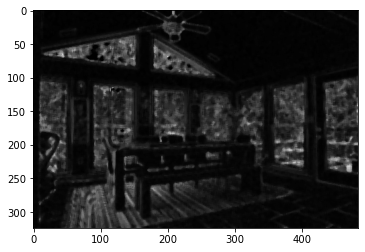

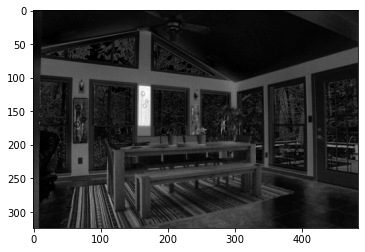

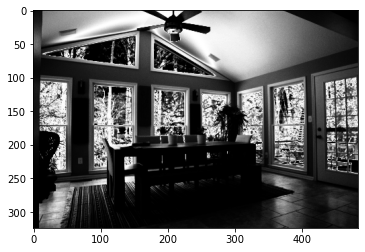

In [2]:
##############################################################################

"""
Carregar imagens e setar o diretório para salvar
"""
#------------------------------------------------------------------------------#
path = r"C:\Users\emanu\Desktop\Projects\exposure-fusion\room"

cwd = os.getcwd();
# Carregar as imagens 
image_stack  = load_images(path)
# Alinhar as imagens 
image_stack  = alignment(image_stack)
resultsPath = cwd+"\\results"
if os.path.isdir(resultsPath) == True:
    os.chdir(resultsPath)
else:
    os.mkdir(resultsPath); 
    os.chdir(resultsPath)

    
"""
Computar as medidas de qualidade e criar o weight map
"""
#------------------------------------------------------------------------------#
weight_map  = scalar_weight_map(image_stack, weights = [1,1,1])


"""
Fusão de exposição multiresolução
"""
#------------------------------------------------------------------------------#
final_imageD = measures_fusion_multires(image_stack, weight_map, levels=6)
cv2.imwrite('img_MultiresolutionFusion2.png', final_imageD.astype('uint8'))


"""
Visualizando as medidas de qualidade para uma imagem qualquer
"""
#------------------------------------------------------------------------------#
visualize_measures(image_stack[4])

os.chdir(cwd)